# Знакомство с данными Spotify


In [1]:
import os
import re
import sys

import os
import re
import copy
import time
import datetime
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [3]:
def cleanse_data(df):
    """
    Удаляем специальные символы из колонок типа StringType 
    (спецсимволы, за исключением , и -, которые могут быть полезны для разделения колонок)
    Преобразуем миллисекунды из колонки ts и создает две новые колонки с типами timestamp и date,
    которые будут использоваться для дальнейшей обработки
    Извлекаем месяц из ts
    Преобразуем идентификатор пользователя в тип LongType
    Разбиваем поле местоположения и оставляет только название штата в качестве местоположения
    :param df: Spark DataFrame
    :return предобработанный Spark DataFrame df
    """
    # Чистим от специальных знаков
    for field in df.schema.fields:
        if field.dataType==StringType():
            df = df.withColumn(field.name, regexp_replace(field.name, '[^a-zA-Z0-9\,\-]', ''))
    
    df = df.withColumn('interaction_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
    df = df.withColumn('month', month(col('interaction_time')))
    df = df.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
    df = df.withColumn('userId', col('userId').cast(LongType()))
    df = df.filter(col('userId').isNotNull())
    df = df.filter(col('auth')!='LoggedOut')
    df = df.withColumn('location', split(col('location'),',').getItem(1))
    
    return df
    

In [4]:
def label_data(df):
    """
    Расчитываем фичи и добавляем столбец с label
    :param df: spark DataFrame
    """
   
    label_df = df.withColumn('label',
                             when((col('page').\
                                   isin(['Cancellation Confirmation','Cancel'])) | \
                                  (col('auth')=='Cancelled'),1 ).\
                             otherwise(0)).\
    groupby('userId').agg(sum('label').alias('label')).\
    withColumn('label', when(col('label')>=1 ,1).otherwise(0))

    df = df.join(label_df, on='userId')

    return df

In [5]:
def registered_days(df):
    """
    Расчитываем количество дней от регистрации до последней активности
    :param df: spark DataFrame
    :return df with calculated column
    """
    last_interaction_df =  df.groupBy('userId').agg(max('ts').alias('last_interaction'))

    df = last_interaction_df.join(df, on='userId').withColumn('registered_days', ((col('last_interaction')-col('registration'))/86400000).cast(IntegerType()))
    return df

In [6]:
spark = SparkSession.builder.appName("Spotify").getOrCreate()

# Считываем датасет Spotify
event_data = "spotify-event-data.json"

In [7]:
df = spark.read.json(event_data)

In [8]:
df.count()

543705

In [9]:
pd.DataFrame(df.take(5), columns=df.columns).head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1532063507000,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1538069638000,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1535953455000,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,246


In [11]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



UserId может быть integer, надо почистить данные

**Посчитаем уникальных пользователей:**

In [12]:
df.select('userId').distinct().count()

449

**За какое время у нас логи?**

In [13]:
df.agg(max(from_unixtime(col('ts')/1000).cast(DateType())),min(from_unixtime(col('ts')/1000).cast(DateType()))).collect()

[Row(max(CAST(from_unixtime((ts / 1000), yyyy-MM-dd HH:mm:ss) AS DATE))=datetime.date(2018, 12, 1), min(CAST(from_unixtime((ts / 1000), yyyy-MM-dd HH:mm:ss) AS DATE))=datetime.date(2018, 10, 1))]

У нас 2 месяца данных: октябрь и ноябрь 2018

**Какие у нас есть страницы?**

In [14]:
df.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade'),
 Row(page='Submit Registration'),
 Row(page='Register')]

**Какие степени/типы авторизации?**

In [15]:
df.select('auth').distinct().collect()

[Row(auth='Logged Out'),
 Row(auth='Cancelled'),
 Row(auth='Guest'),
 Row(auth='Logged In')]

**Что такое level?**

In [16]:
df.select('level').distinct().collect()

[Row(level='free'), Row(level='paid')]

Это подписка или бесплатная версия

In [17]:
df.select('gender').distinct().collect()

[Row(gender='F'), Row(gender='M'), Row(gender=None)]

In [18]:
df.select('status').distinct().collect()

[Row(status=307), Row(status=404), Row(status=200)]

In [19]:
df.select('method').distinct().collect()

[Row(method='PUT'), Row(method='GET')]

**Считаем Null**

In [20]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



**Разберемся, в каких ситуциях у нас artist=Null**

In [21]:
df.where("artist is null").show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  NULL| Logged In| Maverick|     M|          185|Santiago|  NULL| paid|Orlando-Kissimmee...|   PUT|         Logout|1535953455000|      178|NULL|   307|1538352119000|"Mozilla/5.0 (Mac...|   179|
|  NULL|Logged Out|     NULL|  NULL|          186|    NULL|  NULL| paid|                NULL|   GET|           Home|         NULL|      178|NULL|   200|1538352148000|                NULL|      |
|  NULL|Logged Out|     N

In [22]:
set(df.select('page').distinct().collect())-set(df.where("artist is null").select('page').distinct().collect())
    
    

{Row(page='NextSong')}

**Artist, length и song равны Null в случаях, когда пользователь не авторизован или он не на странице NextSong.**

In [24]:
df.where("lastName is null").show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  NULL|Logged Out|     NULL|  NULL|          186|    NULL|  NULL| paid|    NULL|   GET| Home|        NULL|      178|NULL|   200|1538352148000|     NULL|      |
|  NULL|Logged Out|     NULL|  NULL|          187|    NULL|  NULL| paid|    NULL|   GET| Home|        NULL|      178|NULL|   200|1538352151000|     NULL|      |
|  NULL|Logged Out|     NULL|  NULL|          188|    NULL|  NULL| paid|    NULL|   GET| Home|        NULL|      178|NULL|   200|1538352168000|     NULL|      |
|  NULL|Logged Out|     NULL|  NUL

**Когда пользовтель не авторизован, имя и фамилия Null, а UserId пустая строка**

In [25]:
df.select('userId','gender','level','auth').groupby(['gender','level','auth']).count().show()

+------+-----+----------+------+
|gender|level|      auth| count|
+------+-----+----------+------+
|     F| free| Cancelled|    16|
|     F| paid| Logged In|178666|
|     M| paid| Logged In|239311|
|  NULL| free|Logged Out|  5053|
|     F| free| Logged In| 46682|
|     F| paid| Cancelled|    29|
|     M| free| Logged In| 63247|
|  NULL| free|     Guest|    94|
|     M| free| Cancelled|    16|
|  NULL| paid|Logged Out| 10553|
|     M| paid| Cancelled|    38|
+------+-----+----------+------+



**Из таблицы выше видно, что пол Null записан у неавторизованных пользователей и у гостей**

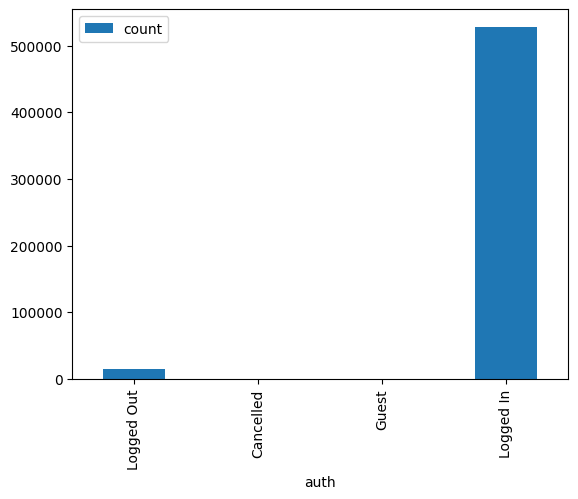

In [27]:
auth_df = df.select('ts', 'auth').groupBy('auth').count().toPandas()
auth_df.index = auth_df.auth
auth_df.plot.bar();

**Функции cleanse_data и label_data определены в начале этого блокнота:**

Эта функция сначала удаляет специальные символы из столбцов типа StringType. Только ',' и '-' не удаляются, потому что мы видим, что поле местоположения, например, может быть разделено с использованием ','.
На основе ts создаются несколько столбцов, один из них имеет тип метки времени, а другой - тип даты, который будет полезен для агрегаций и анализа по времени.
userId преобразуется в тип longtype, чтобы мы могли распознать пустые строки, а затем удаляются строки с нулевыми идентификаторами пользователей.
Записи о выходе из системы бесполезны, так как они не предоставляют идентификатор пользователя и другие полезные поля. Их использование для дальнейшего анализа нецелесообразно.
Наконец, поле местоположения разделяется с использованием ',' и для дальнейшего анализа сохраняется только аббревиатура штата, поскольку это удобно использовать и имеет меньше уникальных значений, учитывая, что оно будет закодировано для моделирования.


In [28]:
df = cleanse_data(df)
df = label_data(df)
df = registered_days(df)

In [33]:
df.select('userId','location','label').distinct().groupby('location','label').count().show()

+--------+-----+-----+
|location|label|count|
+--------+-----+-----+
|      IN|    0|    8|
|      MD|    0|    2|
|      VA|    0|    4|
|      AZ|    0|    8|
|   RI-MA|    1|    2|
|   TN-VA|    1|    1|
|      TN|    1|    1|
|   MN-WI|    0|    7|
|      AZ|    1|    2|
|   VA-NC|    0|    3|
|      OK|    0|    1|
|   GA-AL|    1|    2|
|   RI-MA|    0|    3|
|      NJ|    1|    1|
|      TX|    1|    5|
|   MA-NH|    0|    6|
|      CT|    1|    2|
|      LA|    0|    3|
|      NC|    0|    8|
|      AL|    0|    7|
+--------+-----+-----+
only showing top 20 rows



In [34]:
df.select('userId','gender','label').distinct().groupby('gender','label').count().show()

+------+-----+-----+
|gender|label|count|
+------+-----+-----+
|     M|    1|   54|
|     F|    0|  153|
|     F|    1|   45|
|     M|    0|  196|
+------+-----+-----+



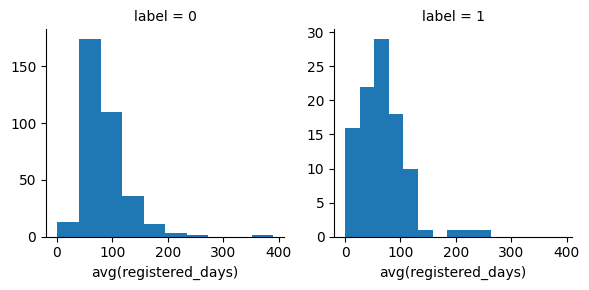

In [35]:
register_df = df.groupBy(['userId', 'label']).avg('registered_days').toPandas()

# Сравниваем подписанных и не подписанных
g = sns.FacetGrid(register_df, col="label", sharey=False)
g.map(plt.hist, "avg(registered_days)");

**Давно зарегистрированные пользователи чаще покупают подписку.**

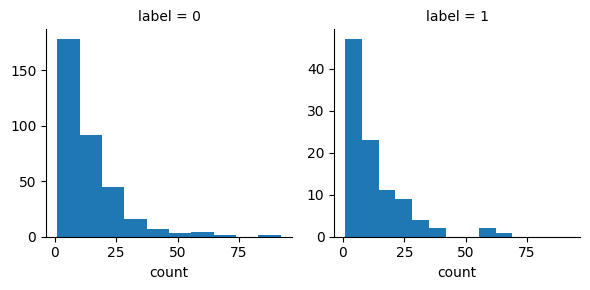

In [36]:
sess_df = df.select('userId', 'label', 'sessionId').distinct().groupBy(['userId', 'label']).count().toPandas()

g = sns.FacetGrid(sess_df, col="label", sharey=False)
g.map(plt.hist, "count");

**У отписавшихся было меньше сессий входа**

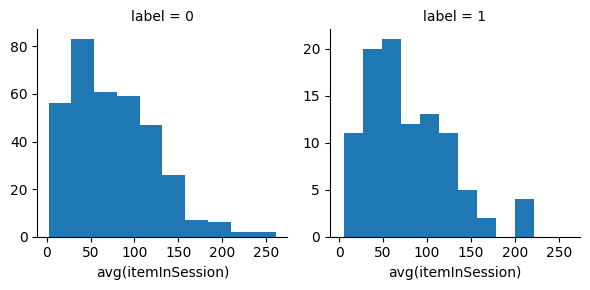

In [37]:
item_df = df.groupBy(['userId', 'label']).avg('itemInSession').toPandas()

# compare two groups of users
g = sns.FacetGrid(item_df, col="label", sharey=False)
g.map(plt.hist, "avg(itemInSession)");

**У отписавшихся меньше средний itemInSession**

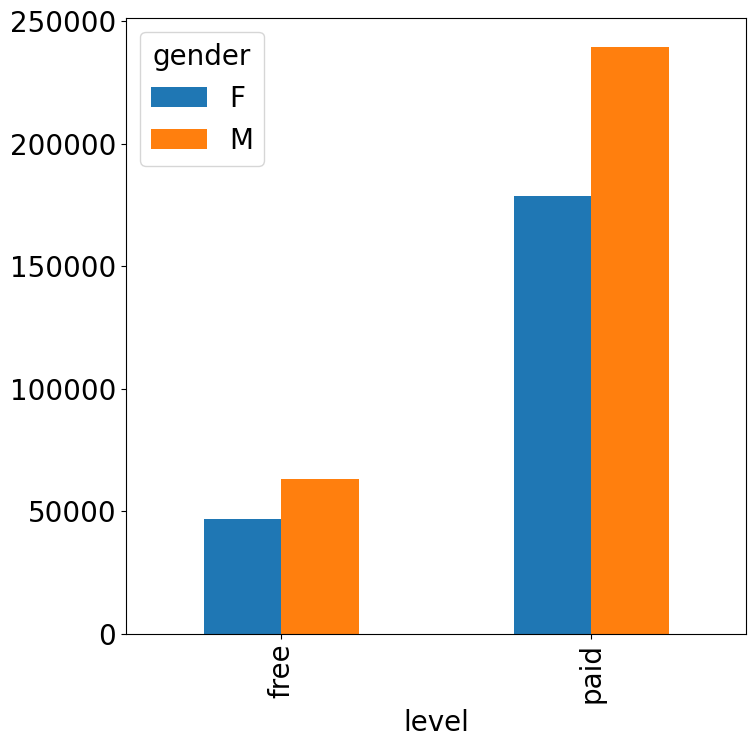

In [41]:
df_count = df.select('userId','gender','level').groupby('gender','level').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
plt.rcParams["font.size"] = "20"
df_count.pivot(index='level', columns='gender', values='count').plot(kind='bar', ax=ax)
plt.savefig('gender_level.png')

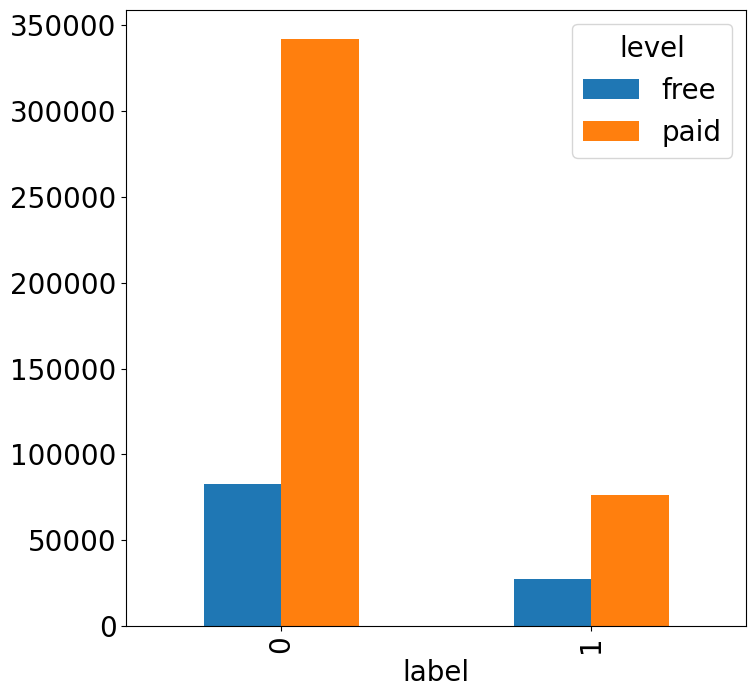

In [42]:
df_count_ = df.select('userId','level','label').groupby('level','label').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
plt.rcParams["font.size"] = "20"
df_count_.pivot(index='label', columns='level', values='count').plot(kind='bar', ax=ax)
plt.savefig('label_level.png')

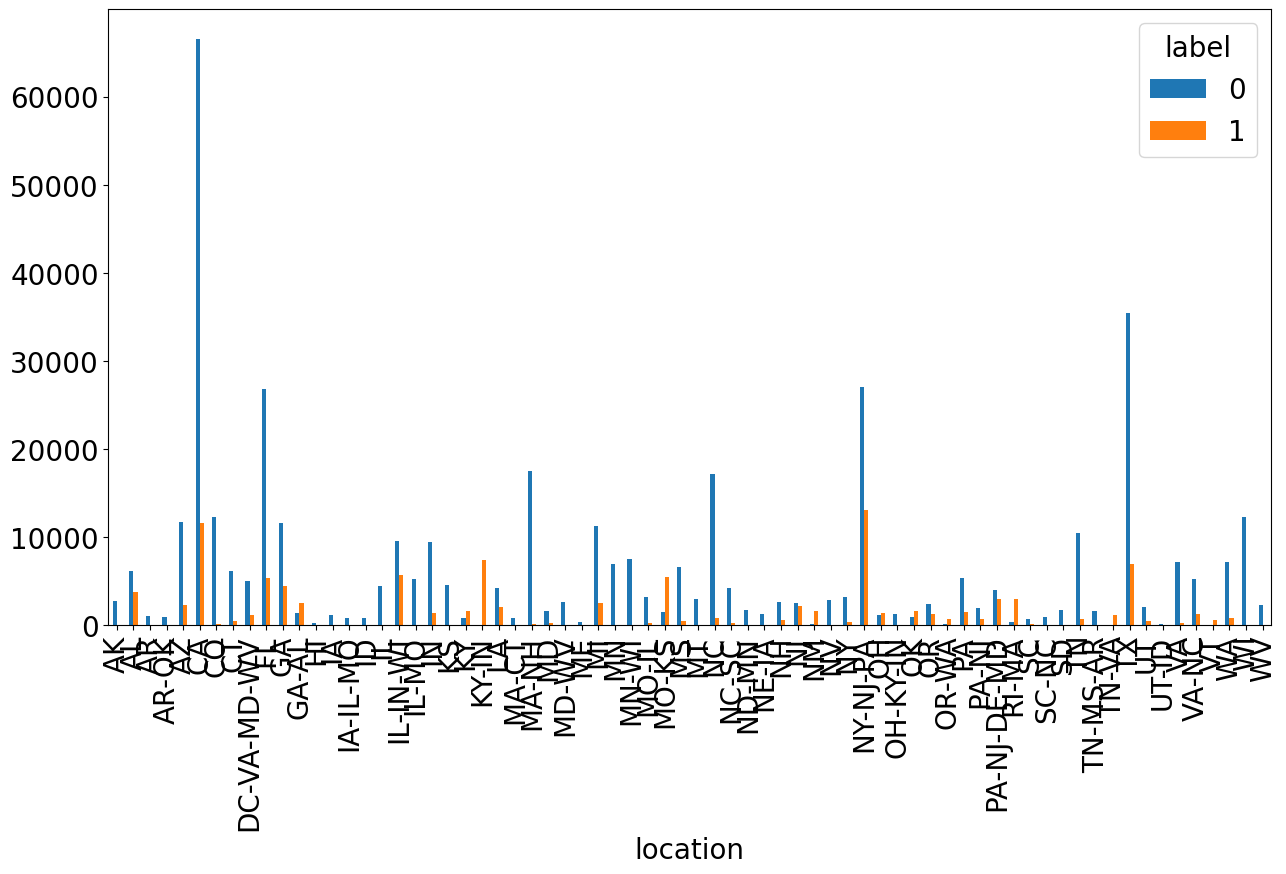

In [44]:
df_state_count_ = df.select('userId','location','label').groupby('location','label').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
df_state_count_.pivot(index='location', columns='label', values='count').plot(kind='bar', ax=ax)
plt.savefig('state_churn.png')



**Из диаграммы видно, что в некоторых штатах выше доля лояльных подписчиков**